In [1]:
!pip install -U matplotlib

Requirement already up-to-date: matplotlib in /usr/local/lib/python3.7/dist-packages (3.4.0)


In [2]:
import numpy as np
from numpy import random
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import matthews_corrcoef as MCC

class one_slab_SVM():
    def __init__(self, v1, v2, epsilone, itr=1000, minC=0.001, kernel_stdev=None, maxP=10):
        if 1/v1 < 1:
            raise Exception('1/v1>=1')
        if 1/v2 < 1:
            raise Exception('1/v2>=1')

        self.epsilone = epsilone
        self.kernel_stdev = kernel_stdev
        self.v1 = v1
        self.v2 = v2
        self.high = 0
        self.highPrime = 0
        self.p1 = 0
        self.p2 = 0
        self.iter = itr
        self.maxP = max(maxP, (int)(0.1*itr))
        self.K = np.zeros(1)
        self.gamma = np.zeros(1)
        self.X = np.zeros(1)
        self.dotMem = np.zeros(1)
        self.minC = minC

    def kernel(self, x1, x2):
        if self.kernel_stdev is None:
            return np.dot(x1.T, x2)
        else:
            return np.exp((-1/2.0)*((np.linalg.norm(x1-x2)/self.kernel_stdev)**2))

    # for linear kernel
    def getW(self):
        if self.kernel_stdev is not None:
            print("Warning! kernel is not linear")
        return np.dot(self.X.T, self.gamma)

    def cGamma(self, a, b, tstar):
        mu = (self.K[a][a]+self.K[b][b]-2*self.K[a][b])
        val = self.dotMem[a]-self.dotMem[b]
        self.gamma[b] * mu + val
        self.gamma[b] = self.gamma[b] + val/mu

    def predict(self, X):
        m2 = X.shape[0]
        ans = np.zeros((m2))

        for i in range(m2):
            val = 0
            for j in range(self.X.shape[0]):
                val += self.gamma[j]*self.kernel(self.X[j], X[i])
            if np.sign((val-self.p1))*np.sign((self.p2-val)) >= 0:
                ans[i] = 1
            else:
                ans[i] = 0
        return ans

    def cKernel(self, X, m):
        self.K = np.zeros((m, m))
        for i in range(m):
            for j in range(m):
                self.K[i][j] = self.kernel(X[j], X[i])

    def minD(self, b):
        val = self.dotMem[b]
        return min(val-self.p1, self.p2-val)

    def getTstar(self, a, b):
        return self.gamma[a]+self.gamma[b]

    def adjustP(self):
        pos = np.where((self.gamma > 0) & (self.gamma < self.high))
        n1 = len(pos[0])
        if n1 == 0:
            return False
        p1 = np.sum(self.dotMem[pos])
        pos = np.where((self.gamma < 0) & (self.gamma > -1*self.highPrime))
        n2 = len(pos[0])
        if n2 == 0:
            return False
        p2 = np.sum(self.dotMem[pos])
        self.p1 = p1/n1
        self.p2 = p2/n2
        return True

    def boundGamma(self, tstar, b):
        high = min(self.high, tstar+self.highPrime)
        low = max(tstar-self.high, -1*self.highPrime)
        self.gamma[b] = min(self.gamma[b], high)
        self.gamma[b] = max(self.gamma[b], low)

    def isVoilating(self, b):
        val = np.sign((self.dotMem[b]-self.p1)) * \
            np.sign((self.p2-self.dotMem[b]))
        g = self.gamma[b]
        if g == 0:
            if val > 0:
                return False
        elif g > -1*self.highPrime and g < 0:
            if val == 0:
                return False
        elif g == -1*self.highPrime:
            if val < 0:
                return False
        elif g > 0 and g < self.high:
            if val == 0:
                return False
        elif g == self.high:
            if val < 0:
                return False
        return True

    def takeStep(self, a, b):
        orgGamma = self.gamma[b]
        tstar = self.getTstar(a, b)
        self.cGamma(a, b, tstar)
        self.boundGamma(tstar, b)
        if abs((orgGamma-self.gamma[b])/(orgGamma + 1e-9)) < self.minC:
            self.gamma[b] = orgGamma
            return False
        self.gamma[a] = tstar-self.gamma[b]
        return True

    def examine(self, b):
        bval = self.minD(b)
        m = len(self.gamma)
        arr = np.zeros((m, 2))
        for i in range(m):
            arr[i][0] = i
            arr[i][1] = -1*abs(bval-self.minD(i))
        arr = arr[arr[:,1].argsort()]
        for v in arr:
            if v[0] == b:
                continue
            gammaB = self.gamma[b]
            gammaA = self.gamma[(int)(v[0])]
            if self.takeStep((int)(v[0]), b):
                self.dotMem = np.dot(self.K, self.gamma)
                if not self.adjustP():
                    self.gamma[b] = gammaB
                    self.gamma[(int)(v[0])] = gammaA
                    continue
                return True
        return False

    def fit(self, X):
        m, _ = X.shape
        self.X = X
        self.high = 1/(self.v1*m)
        self.highPrime = self.epsilone/(self.v2*m)
        self.gamma = np.random.rand(
            m)*(self.high + self.highPrime)-self.highPrime
        print(np.min(self.gamma), np.max(self.gamma))
        self.cKernel(X, m)
        self.dotMem = np.dot(self.K, self.gamma)
        self.p2 = np.max(self.dotMem)
        self.p1 = np.min(self.dotMem)
        if self.p1 == 0:
            self.p1 = random.uniform(-m, -m/2)
        if self.p2 == 0:
            self.p2 = random.uniform(m/2, m)
        w = np.array([0, 0])
        if self.kernel_stdev is None:
            w = self.getW()
        print('On start')
        if w[0] and w[1]:
            plt.figure(figsize=(8, 8))
            plt.scatter(X[:, 0], X[:, 1])
            plt.axline(((self.p1-w[1])/w[0], 1),(1, (self.p1-w[0])/w[1]), c='r')
            plt.axline(((self.p2-w[1])/w[0], 1),(1, (self.p2-w[0])/w[1]), c='g')
            plt.show()
        KKTviolators = 0
        for i in range(m):
            if self.isVoilating(i):
                KKTviolators += 1
        k = {'KKT voilators Count': KKTviolators,
             'Maximisation Function Value': -1/2*np.dot(self.dotMem, self.gamma)}
        print(k)
        handleAll = 1
        passes = 0
        for _ in range(self.iter):
            b = -1
            if handleAll:
                b = random.randint(0, m-1)
            else:
                mval = -1
                for i in range(m):
                    val = abs(self.minD(i))
                    if val > mval:
                        mval = val
                        b = i
            flag = self.examine(b)
            if flag:
                passes = 0
            else:
                passes = passes + 1
                if passes > self.maxP:
                    break
            if handleAll:
                handleAll = 0
            elif flag == False:
                handleAll = 1
            KKTviolators = 0

            for i in range(m):
                if self.isVoilating(i):
                    KKTviolators += 1
                    if KKTviolators >= 2:
                        break
            if KKTviolators < 2:
                break
        print('At end')

        if self.kernel_stdev is None:
            w = self.getW()
        if w[0] and w[1]:
            plt.figure(figsize=(8, 8))
            plt.scatter(X[:, 0], X[:, 1])
            plt.axline(((self.p1-w[1])/w[0], 1),(1, (self.p1-w[0])/w[1]), c='r')
            plt.axline(((self.p2-w[1])/w[0], 1),(1, (self.p2-w[0])/w[1]), c='g')
            plt.show()
        KKTviolators = 0
        for i in range(m):
            if self.isVoilating(i):
                KKTviolators += 1
        k = {'KKT voilators count': KKTviolators,
             'Maximisation Function Value': -1/2*np.dot(self.dotMem, self.gamma)}
        print(k)
        return k

In [3]:
XG, YG = make_classification(n_samples=2000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1,scale=100)

In [4]:
mean=np.mean(XG)
stdev=np.sqrt(np.var(XG))
XG = (XG-mean)/stdev

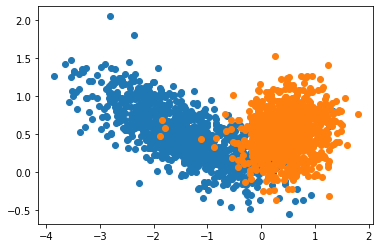

In [5]:
for class_value in range(2):
    row_ix = np.where(YG == class_value)
    plt.scatter(XG[row_ix, 0], XG[row_ix, 1])
plt.show()

In [6]:
subI=np.argwhere(YG==1)
subI=subI.flatten()
Xsub=XG[subI]
print(XG.shape,subI[:-1].shape,Xsub.shape)

(2000, 2) (1000,) (1001, 2)


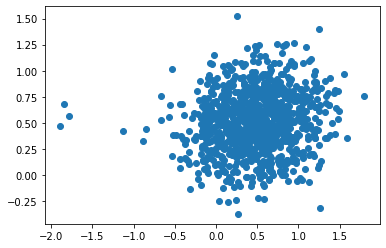

In [7]:
plt.scatter(Xsub[:,0], Xsub[:,1])
plt.show()

### Linear Kernel

0.008805211841250892 9.972099653427499
On start


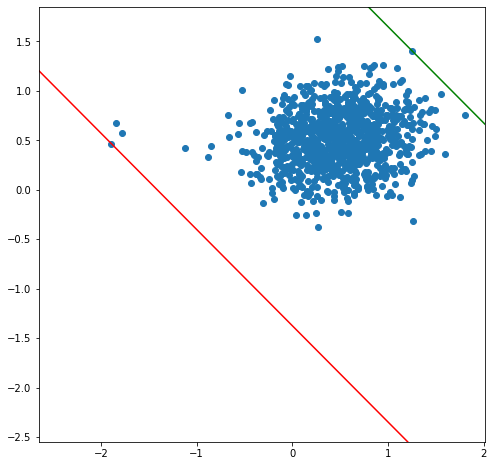

{'KKT voilators Count': 999, 'Maximisation Function Value': -6172441.812514322}
At end


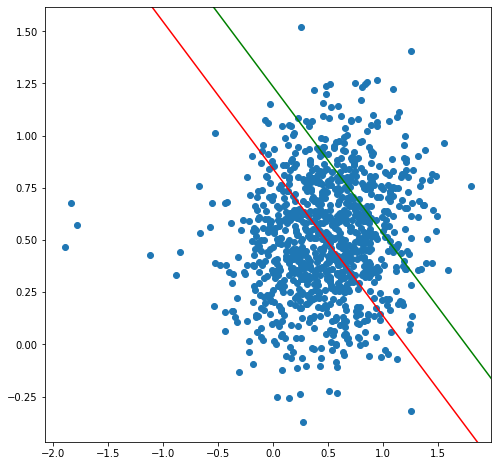

{'KKT voilators count': 474, 'Maximisation Function Value': -2025274.730029752}
{'KKT voilators count': 474, 'Maximisation Function Value': -2025274.730029752}


In [8]:
kernel_stdev=None
svm=one_slab_SVM(v1=0.0001, v2=0.09, epsilone=2/3, itr=10000 ,kernel_stdev=None)
k=svm.fit(Xsub)
print(k)

In [9]:
if kernel_stdev is None:
    w=svm.getW()
    print(w,svm.p1,svm.p2)

[1158.30932608 1645.8642001 ] 1384.548856128556 2031.4556573764648


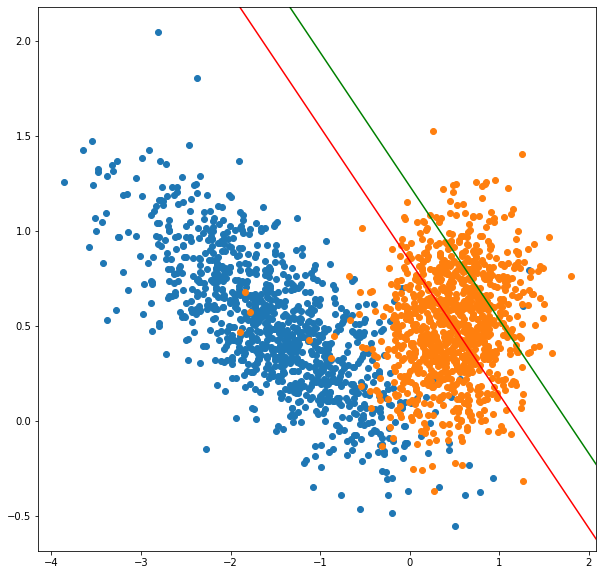

In [10]:
plt.figure(figsize=(10, 10))
for class_value in range(2):
    row_ix = np.where(YG == class_value)
    plt.scatter(XG[row_ix, 0], XG[row_ix, 1])

if kernel_stdev is None:
    plt.axline(((svm.p1-w[1])/w[0], 1), (1, (svm.p1-w[0])/w[1]),c='r')
    plt.axline(((svm.p2-w[1])/w[0], 1), (1, (svm.p2-w[0])/w[1]),c='g')
plt.show()

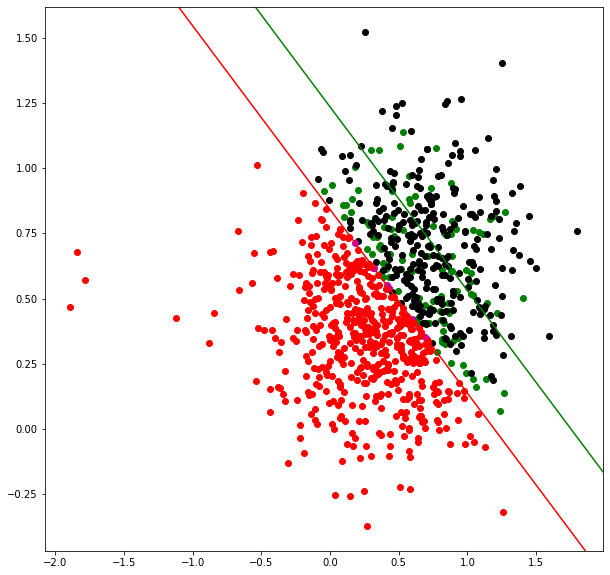

In [12]:
plt.figure(figsize=(10, 10))

rx = np.where(svm.gamma == -1*svm.highPrime)
plt.scatter(Xsub[rx,0], Xsub[rx,1],c='g')

rx = np.where((svm.gamma > -1*svm.highPrime) & (svm.gamma < 0))
plt.scatter(Xsub[rx,0], Xsub[rx,1],c='k')

rx = np.where(svm.gamma == 0)
plt.scatter(Xsub[rx,0], Xsub[rx,1],c='b')

rx = np.where((svm.gamma>0) & (svm.gamma<svm.high))
plt.scatter(Xsub[rx,0], Xsub[rx,1],c='m')

rx = np.where(svm.gamma == svm.high)
plt.scatter(Xsub[rx,0], Xsub[rx,1],c='r')

if kernel_stdev is None:
    plt.axline(((svm.p1-w[1])/w[0], 1), (1, (svm.p1-w[0])/w[1]),c='r')
    plt.axline(((svm.p2-w[1])/w[0], 1), (1, (svm.p2-w[0])/w[1]),c='g')

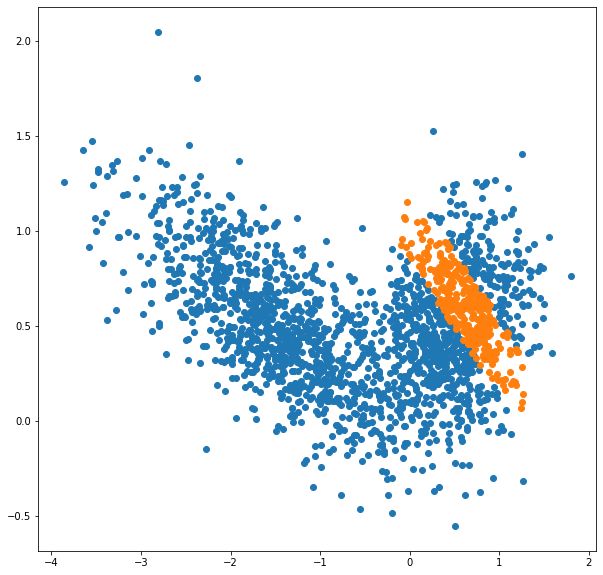

In [13]:
predictions =svm.predict(XG)
plt.figure(figsize=(10, 10))

for i in range(2):
    rx = np.where(predictions == i)
    plt.scatter(XG[rx, 0], XG[rx, 1])

In [14]:
print(MCC(YG,predictions))

0.4303089042045436


### RBF Kernel

In [15]:
kernel_stdev=1
svm=one_slab_SVM(v1=0.0001, v2=0.09, epsilone=2/3, itr=10000 ,kernel_stdev=kernel_stdev)
k=svm.fit(Xsub)
print(k)

-0.0021660554916411775 9.978189204917655
On start
{'KKT voilators Count': 999, 'Maximisation Function Value': -10532050.555550572}
At end
{'KKT voilators count': 424, 'Maximisation Function Value': -9144338.251333324}
{'KKT voilators count': 424, 'Maximisation Function Value': -9144338.251333324}


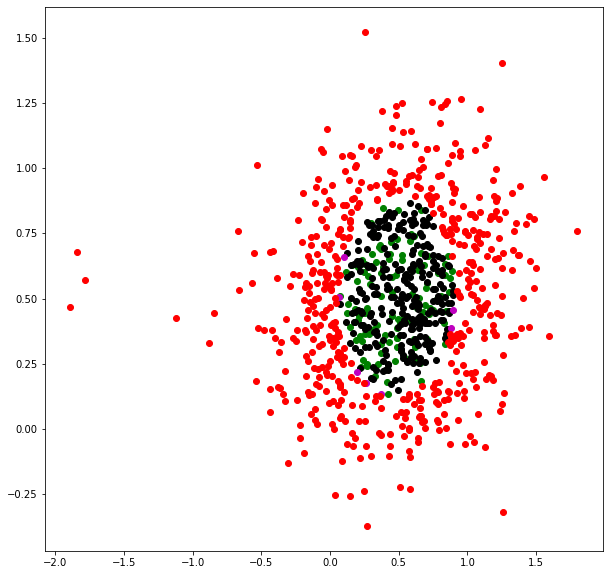

In [16]:
plt.figure(figsize=(10, 10))

rx = np.where(svm.gamma == -1*svm.highPrime)
plt.scatter(Xsub[rx,0], Xsub[rx,1],c='g')

rx = np.where((svm.gamma > -1*svm.highPrime) & (svm.gamma < 0))
plt.scatter(Xsub[rx,0], Xsub[rx,1],c='k')

rx = np.where(svm.gamma == 0)
plt.scatter(Xsub[rx,0], Xsub[rx,1],c='b')

rx = np.where((svm.gamma>0) & (svm.gamma<svm.high))
plt.scatter(Xsub[rx, 0], Xsub[rx, 1],c='m')

rx = np.where(svm.gamma == svm.high)
plt.scatter(Xsub[rx, 0], Xsub[rx, 1],c='r')

In [17]:
predictions = svm.predict(XG)

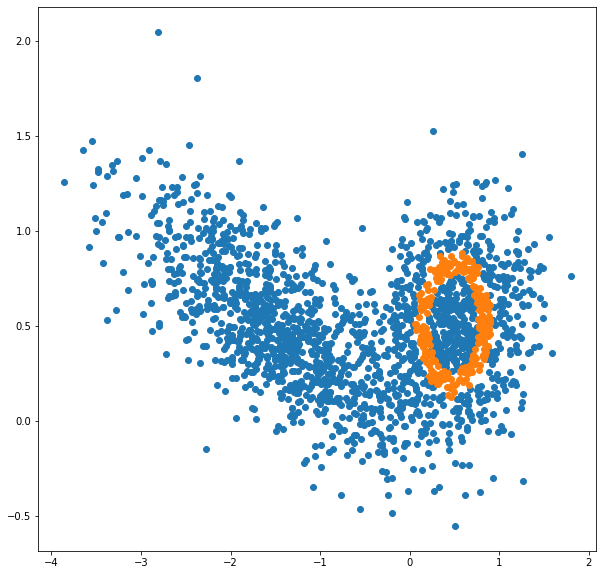

In [18]:
plt.figure(figsize=(10, 10))

for i in range(2):
    rx = np.where(predictions == i)
    plt.scatter(XG[rx,0], XG[rx,1])

In [19]:
print(MCC(YG,predictions))

0.3589028765564099
